In [766]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from scipy.optimize import curve_fit
import matplotlib.patches as mpatches
from scipy.special import ellipk
from scipy.integrate import quad

#plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 140

directory="saved"

SCFiles = glob(directory+"/*SC*")
EMFiles = glob(directory+"/*EM*")

SCs=[]
for SCFile in SCFiles:
    try:
        SC = pd.read_csv(SCFile, skiprows=[0,1,2])
        SC = SC.iloc[:,:-1]
        SCs.append(SC)
    except Exception:
        print(f"{SCFile} failed")

EMs=[]
for EMFile in EMFiles:
    EM = pd.read_csv(EMFile, skiprows=[0,1,2])
    EMs.append(EM)


EMMean = pd.concat(EMs).groupby(level=0).mean()
EMErr = pd.concat(EMs).groupby(level=0).std()/np.sqrt(len(EMs))
SCMean = pd.concat(SCs).groupby(level=0).mean()
SCErr = pd.concat(SCs).groupby(level=0).std()/np.sqrt(len(SCs))

trueTc=2/np.log(1+np.sqrt(2))

def formatErr(val,err,exponent=True):
    factor=int(np.floor(np.log10(abs(err))))
    if exponent:
        return f"({round(val*10**-factor)} \pm {round(err*10**-factor)})\\times 10^{{{factor}}}"
    else:
        print(factor)
        return f"{str(round(val*10**-factor)*10**factor)[0:-factor+2]} \pm {str(round(err*10**-factor)*10**factor)[0:-factor+2]}"

def calcRChiSq(observations, errs, predicted, dof):
    variances=np.square(errs)
    residuals=(observations-predicted)

    return np.sum(residuals**2/variances)/(len(observations)-dof)


saved/1.20T3.20_SC_v6.csv failed


[ 2.27954202e+00  6.38714207e-05 -1.00005135e+00]->[ 2.28081356e+00  6.26300296e-05 -1.00004907e+00]
[ 2.19387533e+00  4.59815031e-05 -1.00000726e+00]->[ 2.22305317e+00  4.10639117e-05 -1.00000347e+00]
1.553665871285765 1.1724903504189337
alpha = 6.263002960065892e-05 +- 2.638777279423088e-06 Tc = 2.251933362712688+-0.012927800731676617
alpha = 4.106391172611276e-05 +- 7.390914877263865e-07 
True Tc: 2.269185314213022
-2


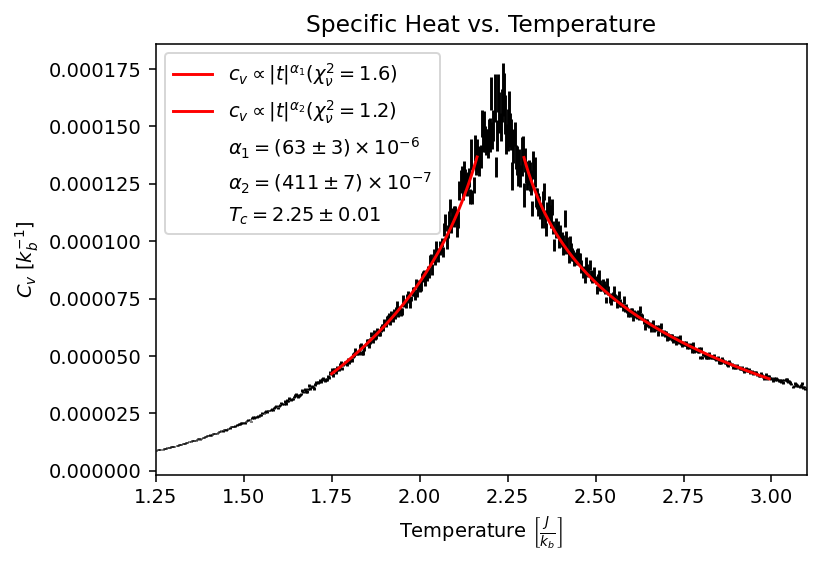

In [784]:
#THEORETICAL CALCULATIONS
def Kappa(T):
  return 2*np.sinh(2/T)/(np.cosh(2/T))**2

def K1(T):
  return ellipk(Kappa(T))

def E(T):
  return -2*np.tanh(1/T)-(((np.sinh(2/T))**2-1)/(np.sinh(2/T)*np.cosh(2/T)))*(2*K1(T)/np.pi-1)

def CvTheory(temps, spacing):
  energies=E(temps)
  cv_array=np.gradient(energies, spacing)
  return cv_array


#EXPERIMENTAL CALCULATIONS

EMMean["Cv"]=EMMean["Temp"]**-2*EMMean["E_std"]**2
EMErr["Cv"]=2*EMMean["Temp"]**-2*EMMean["E_std"]*EMErr["E_std"]

plt.errorbar(EMMean["Temp"], EMMean["Cv"], yerr=EMErr["Cv"], color="k", linestyle="")


leftMin=1.75
leftMax=trueTc-0.1
rightMin=trueTc+0.025
rightMax=3

leftMinI = np.where(EMMean["Temp"] > leftMin)[0][0]
leftMaxI = np.where(EMMean["Temp"] < leftMax)[0][-1]
rightMinI = np.where(EMMean["Temp"] > rightMin)[0][0]
rightMaxI = np.where(EMMean["Temp"] < rightMax)[0][-1]



def spike(x,Tc,a,c):
    return np.abs((x-Tc)/Tc)**-a+c

#First fit the curves without error
lpopt0, lpcov = curve_fit(spike,EMMean["Temp"][leftMinI:leftMaxI],EMMean["Cv"][leftMinI:leftMaxI], p0=(2.26,0,0))
rpopt0, rpcov = curve_fit(spike,EMMean["Temp"][rightMinI:rightMaxI],EMMean["Cv"][rightMinI:rightMaxI], p0=(2.26,0,0))


#Then refit with error, using the previous result as our initial guiss
lpopt, lpcov = curve_fit(spike,EMMean["Temp"][leftMinI:leftMaxI],EMMean["Cv"][leftMinI:leftMaxI], p0=lpopt0, sigma = EMErr["Cv"][leftMinI:leftMaxI])
rpopt, rpcov = curve_fit(spike,EMMean["Temp"][rightMinI:rightMaxI],EMMean["Cv"][rightMinI:rightMaxI], p0=rpopt0, sigma = EMErr["Cv"][rightMinI:rightMaxI])

print(f"{lpopt0}->{lpopt}")
print(f"{rpopt0}->{rpopt}")

rChiSql=calcRChiSq(EMMean["Cv"][leftMinI:leftMaxI],EMErr["Cv"][leftMinI:leftMaxI],spike(EMMean["Temp"][leftMinI:leftMaxI],*lpopt),3)
rChiSqr=calcRChiSq(EMMean["Cv"][rightMinI:rightMaxI],EMErr["Cv"][rightMinI:rightMaxI],spike(EMMean["Temp"][rightMinI:rightMaxI],*rpopt),3)

plt.plot(EMMean["Temp"][leftMinI:leftMaxI],spike(EMMean["Temp"][leftMinI:leftMaxI],*lpopt), zorder=20, color="r", label=f"$c_v \propto |t|^{{\\alpha_1}}  (\chi_\\nu^2 = {round(rChiSql,1)})$ ")
plt.plot(EMMean["Temp"][rightMinI:rightMaxI],spike(EMMean["Temp"][rightMinI:rightMaxI],*rpopt), zorder=20, color="r", label=f"$c_v \propto |t|^{{\\alpha_2}}  (\chi_\\nu^2 = {round(rChiSqr,1)})$")





print(rChiSql,rChiSqr)

predTc = (lpopt[0]+rpopt[0])/2
predTcErr = (np.sqrt(lpcov[0][0])+np.sqrt(rpcov[1][1]))

print(f"alpha = {lpopt[1]} +- {np.sqrt(lpcov[1][1])} Tc = {predTc}+-{predTcErr}")
print(f"alpha = {rpopt[1]} +- {np.sqrt(rpcov[1][1])} ")
print(f"True Tc: {trueTc}")


handles, labels = plt.gca().get_legend_handles_labels() # get existing handles and labels
empty_patch = mpatches.Patch(color='none', label='') # create a patch with no color
handles+=[empty_patch]*4  # add new patches and labels to list
labels.append(f"$\\alpha_1 = {formatErr(lpopt[1],np.sqrt(lpcov[1][1]))}$")
labels.append(f"$\\alpha_2 = {formatErr(rpopt[1],np.sqrt(rpcov[1][1]))}$")
labels.append(f"$T_{{c}} = {formatErr(predTc,predTcErr,exponent=False)}$")

plt.xlabel("Temperature $\\left[\\frac{J}{k_b}\\right]$")
plt.ylabel("$C_v$ [$k_b^{-1}$]")
plt.legend(handles,labels)
plt.title("Specific Heat vs. Temperature")
plt.savefig("alpha.png")
plt.xlim(1.25,3.1)


#xs=np.linspace(1.25,3.1,1000)
#plt.plot(xs,CvTheory(xs,(3.1-1.25)/1000))

plt.show()


Tc = 2.222894685858178+-0.0069026346544903945 (-2.0399668579248758% error)
beta = 0.10490242773483072 +- 0.009209167047014128 (-16.078057812135427% error)
-3
-3


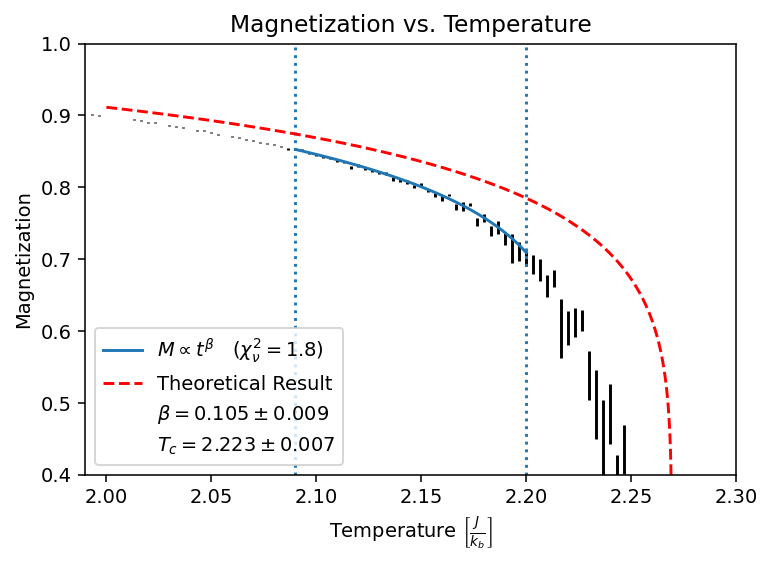

In [795]:


EMMean["M_abs"]=np.abs(EMMean["M_mean"])
#Is error propogation for absolute value just the same error?

#plt.plot(EMMean["Temp"], EMMean["M_abs"], "o", color="k")
plt.errorbar(EMMean["Temp"], EMMean["M_abs"], yerr=EMErr["M_mean"], ls="none",color="k")

tMin = 2.09
tMax=2.20
plt.xlim(tMin-0.1, tMax+0.1)
plt.axvline(tMin, ls=":")
plt.axvline(tMax,ls=":")

iMin = np.where(EMMean["Temp"] > tMin)[0][0]
iMax = np.where(EMMean["Temp"] < tMax)[0][-1]+2

def sloop(t,Tc,beta,b):
    return b*np.abs((t-Tc)/Tc)**beta

popt,pcov = curve_fit(sloop,EMMean["Temp"][iMin:iMax],EMMean["M_abs"][iMin:iMax], p0=(2.2,0.125,1))
popt,pcov = curve_fit(sloop,EMMean["Temp"][iMin:iMax],EMMean["M_abs"][iMin:iMax], p0=popt, sigma=EMErr["M_mean"][iMin:iMax])

rChiSq=calcRChiSq(EMMean["M_abs"][iMin:iMax], EMErr["M_mean"][iMin:iMax], sloop(EMMean["Temp"][iMin:iMax],*popt),3 )
plt.plot(EMMean["Temp"][iMin:iMax],sloop(EMMean["Temp"][iMin:iMax],*popt),label=f"$M\propto t^\\beta \quad (\chi_\\nu^2 = {round(rChiSq,1)})$")


def M(T):
  return np.abs(1-(np.sinh(2/T)**-4))**(1/8)

xs=np.linspace(2,trueTc,1000)
plt.plot(xs,M(xs),"--",color="red", label = "Theoretical Result")


print(f"Tc = {popt[0]}+-{np.sqrt(pcov[0][0])} ({(popt[0]-trueTc)/trueTc*100}% error)")
print(f"beta = {popt[1]} +- {np.sqrt(pcov[1][1])} ({(popt[1]-0.125)/0.125*100}% error)")

handles, labels = plt.gca().get_legend_handles_labels() # get existing handles and labels
empty_patch = mpatches.Patch(color='none', label='') # create a patch with no color
handles+=[empty_patch]*4  # add new patches and labels to list

labels.append(f"$\\beta = {formatErr(popt[1],np.sqrt(pcov[1][1]), exponent=False)}$")
labels.append(f"$T_{{c}} = {formatErr(popt[0],np.sqrt(pcov[0][0]), exponent=False)}$")

plt.ylim(0.4,1)
plt.legend(handles,labels)
plt.title("Magnetization vs. Temperature")
plt.xlabel("Temperature $\\left[\\frac{J}{k_b}\\right]$")
plt.ylabel("Magnetization")



plt.savefig("beta.png")


eta = 0.24519342165735275+-0.02440241554432183 (-1.9226313370588999% error)
[ 0.46150784 -0.00274054  0.00742998]
-2


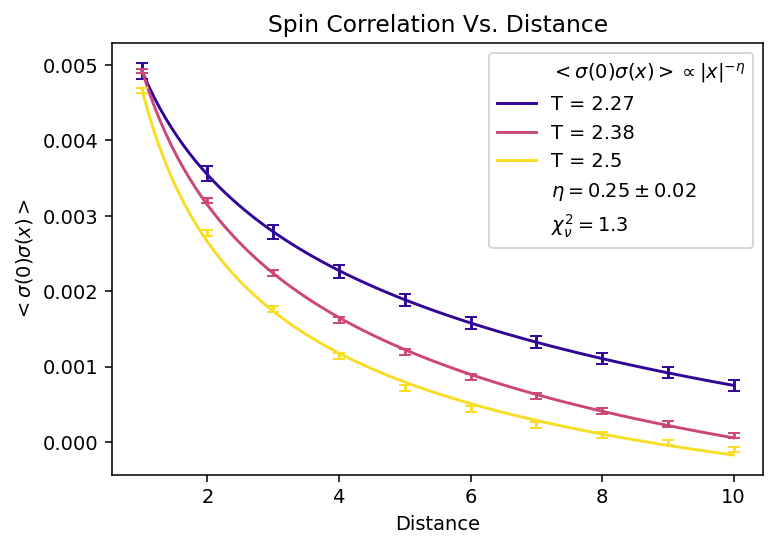

In [754]:
def correlationFalloff(x,eta,c,a):
    return a*np.abs(x)**(-eta)+c


tMin=trueTc
tMax=2.5
nMax=10

etas=[]
etaErrs=[]

chiSqs=[]

SCRows=SCMean[np.logical_and(SCMean["Temp"]>tMin,SCMean["Temp"]<tMax)]
SCErrRows=SCErr[np.logical_and(SCMean["Temp"]>tMin,SCMean["Temp"]<tMax)]
colors=mpl.colormaps['plasma'].resampled(len(SCRows)+10)
for i in range(len(SCRows)):

    temp=SCRows["Temp"].values[i]

    correlations=SCRows.iloc[i][1:nMax+1]
    errs=SCErrRows.iloc[i][1:nMax+1]

    xVals=np.arange(1,len(correlations)+1)

    popt,pcov = curve_fit(correlationFalloff, xVals, correlations, maxfev=5000, sigma=errs)
    etas.append(popt[0])
    etaErrs.append(np.sqrt(pcov[0][0]))

    chiSqs.append(calcRChiSq(correlations, errs, correlationFalloff(xVals, *popt), 3))

    if i==0 or i==len(SCRows)-1 or i==len(SCRows)//2:
        xData = np.linspace(min(xVals),max(xVals),100)
        plt.plot(xData, correlationFalloff(xData, *popt), color=colors.colors[i+5], label = f"T = {round(temp,2)}")
        plt.errorbar(xVals, correlations, yerr=errs, color=colors.colors[i+5], ls="none", capsize=3)

    

etaAverageErr=np.std(etas)/len(etas)
etaFitErr=np.sqrt(np.sum(np.array(etaErrs)**2))/np.sqrt(len(etaErrs))
etaErr=np.sqrt(etaFitErr**2+etaAverageErr**2)

eta=np.mean(etas)

print(f"eta = {eta}+-{etaErr} ({(eta-0.25)/0.25*100}% error)")
print(popt)

handles, labels = plt.gca().get_legend_handles_labels() # get existing handles and labels
empty_patch = mpatches.Patch(color='none', label='') # create a patch with no color
handles.insert(0,empty_patch)
handles+=[empty_patch]*4  # add new patches and labels to list

labels.insert(0,f"$<\\sigma(0)\\sigma(x)> \propto |x|^{{-\eta}}$")
labels.append(f"$\\eta = {formatErr(eta,etaErr, exponent=False)}$")
labels.append(f"$\\chi_\\nu^2 = {round(np.mean(chiSqs),1)}$")



plt.legend(handles,labels)
plt.xlabel("Distance")
plt.ylabel("$<\\sigma(0)\\sigma(x)>$")
plt.title("Spin Correlation Vs. Distance")
plt.savefig("eta.png")
plt.show()



Tc = 1.9114750867444494+-0.04441781949449111 (-15.763817314877626% error)
nu = 0.9013521960108423 +- 0.06649613105253774 (-9.864780398915773% error)
-2
0.3313025909110148


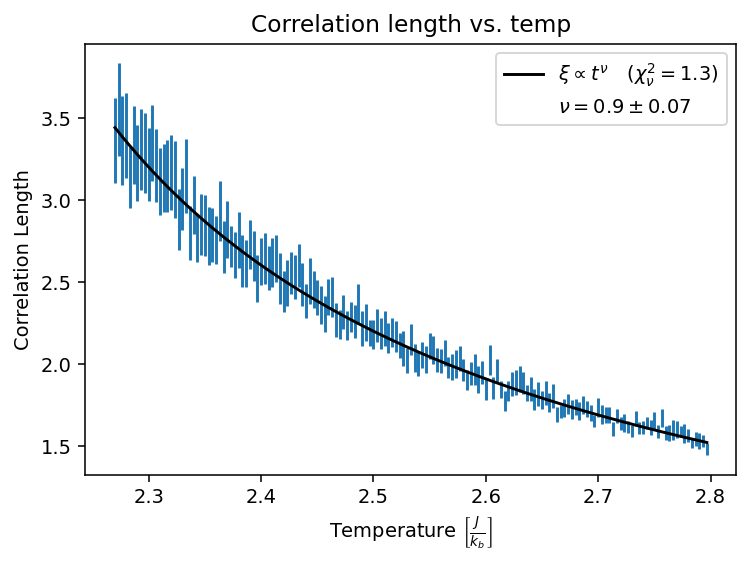

In [764]:
def correlationFalloff(d,xi,c,a):
    return a*np.exp(-d/xi)+c

tMin=trueTc
tMax=2.8#2.8 
nMax=10

xis=[]
xiErrs=[]

SCRows=SCMean[np.logical_and(SCMean["Temp"]>tMin,SCMean["Temp"]<tMax)]
SCErrRows=SCErr[np.logical_and(SCMean["Temp"]>tMin,SCMean["Temp"]<tMax)]
colors=mpl.colormaps['plasma'].resampled(len(SCRows))

for i in range(len(SCRows)):

    temp=SCRows["Temp"].values[i]

    correlations=SCRows.iloc[i][1:nMax+1]
    errs=SCErrRows.iloc[i][1:nMax+1]

    xVals=np.arange(1,len(correlations)+1)

    popt,pcov = curve_fit(correlationFalloff, xVals, correlations, maxfev=5000, sigma=errs)
    xis.append(popt[0])
    xiErrs.append(np.sqrt(pcov[0][0]))

    if False:
        plt.plot(xVals, correlationFalloff(xVals, *popt), color=colors.colors[i])
        plt.errorbar(xVals, correlations, yerr=errs, color=colors.colors[i], ls="none", capsize=3)

plt.errorbar(SCRows["Temp"],xis,yerr=xiErrs, ls="none")

def correlationVTemp(t,Tc,nu,a):
    return a*abs((t-Tc)/Tc)**-nu
popt,pcov = curve_fit(correlationVTemp, SCRows["Temp"], xis, maxfev=50000, sigma=xiErrs, p0=(2,1,1))


rChiSq = calcRChiSq(xis, xiErrs, correlationVTemp(SCRows["Temp"],*popt), 3)

plt.plot(SCRows["Temp"],correlationVTemp(SCRows["Temp"],*popt), color="k", label=f"$\\xi \propto t^{{\\nu}} \quad (\\chi_\\nu^2 = {round(np.mean(chiSqs),1)})$")


print(f"Tc = {popt[0]}+-{np.sqrt(pcov[0][0])} ({(popt[0]-trueTc)/trueTc*100}% error)")
print(f"nu = {popt[1]} +- {np.sqrt(pcov[1][1])} ({(popt[1]-1)/1*100}% error)")

handles, labels = plt.gca().get_legend_handles_labels() # get existing handles and labels
empty_patch = mpatches.Patch(color='none', label='') # create a patch with no color
handles+=[empty_patch]*4  # add new patches and labels to list


labels.append(f"$\\nu= {formatErr(popt[1],np.sqrt(pcov[1][1]), exponent=False)}$")

print(calcRChiSq(xis,xiErrs,correlationVTemp(SCRows["Temp"],*popt),3))

plt.legend(handles,labels)
plt.xlabel("Temperature $\\left[\\frac{J}{k_b}\\right]$")
plt.ylabel("Correlation Length")
plt.title("Correlation length vs. temp")
plt.savefig("nu.png")

[ 1.55795084e+00  1.28860200e-04  7.45090395e+03 -7.45070038e+03]
Tc = 1.5579508424363382+-0.06458414487716464 (-31.343163880088287% error)
gamma = 0.00012886020023812286 +- 0.0006848128103820522 (-99.9926365599864% error)


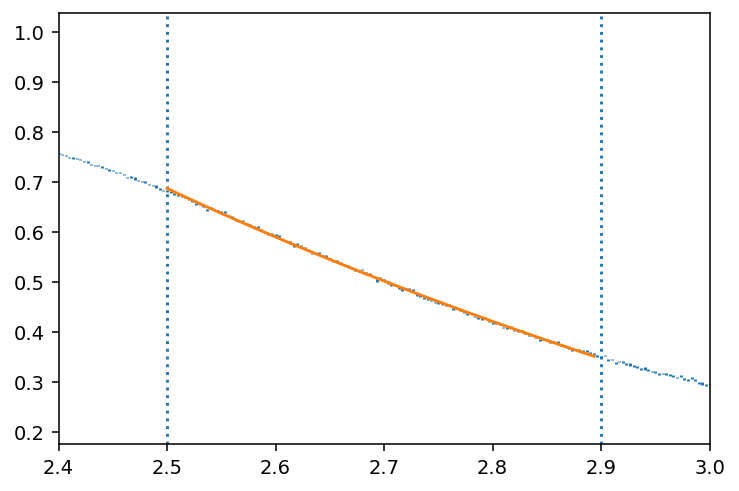

In [656]:
directory="withBField"

SCFiles = glob(directory+"/*SC*")
EMFiles = glob(directory+"/*EM*")

BSCs=[]
for SCFile in SCFiles:
    try:
        SC = pd.read_csv(SCFile, skiprows=[0,1,2])
        SC = SC.iloc[:,:-1]
        BSCs.append(SC)
    except Exception:
        print(f"{SCFile} failed")

BEMs=[]
for EMFile in EMFiles:
    EM = pd.read_csv(EMFile, skiprows=[0,1,2])
    BEMs.append(EM)


BEMMean = pd.concat(BEMs).groupby(level=0).mean()
BEMErr = pd.concat(BEMs).groupby(level=0).std()/np.sqrt(len(BEMs))
BSCMean = pd.concat(BSCs).groupby(level=0).mean()
BSCErr = pd.concat(BSCs).groupby(level=0).std()/np.sqrt(len(BSCs))




tMin = 2.5
tMax=2.9
plt.xlim(tMin-0.1, tMax+0.1)
plt.axvline(tMin, ls=":")
plt.axvline(tMax,ls=":")

iMin = np.where(BEMMean["Temp"] > tMin)[0][0]
iMax = np.where(BEMMean["Temp"] < tMax)[0][-1]



plt.errorbar(BEMMean["Temp"],np.abs(BEMMean["M_mean"]),yerr=BEMErr["M_mean"],ls="")


def func(t,Tc,gamma,a,b):
    return a*np.abs((t-Tc)/Tc)**-gamma+b

popt,pcov =curve_fit(func,BEMMean["Temp"][iMin:iMax],BEMMean["M_mean"][iMin:iMax], maxfev=500000, p0=(2.01,4.5,1e5,0))
#popt=(2,7/4,0.1,-0.0)
print(popt)

plt.plot(BEMMean["Temp"][iMin:iMax],func(BEMMean["Temp"][iMin:iMax],*popt))

print(f"Tc = {popt[0]}+-{np.sqrt(pcov[0][0])} ({(popt[0]-trueTc)/trueTc*100}% error)")
print(f"gamma = {popt[1]} +- {np.sqrt(pcov[1][1])} ({(popt[1]-7/4)/(7/4)*100}% error)")